# Predict housing prices 

In this notebook, we are going to train a Random Forest model for predicting the housing prices using the dataset from the [Housing Prices Competition for Kaggle Learn Users](https://www.kaggle.com/c/home-data-for-ml-course).

We will first do some basic processing of the data, e.g., handling missing values and encoding of categorical variables. Here we try label encoding, target encoding and catboost encoding. We will implement One-Hot encoding in another notebook. 

We start by training a baseline model with numerical variables only. Then add encoded categorical variables and drop some variables (manually select by intuition features that are not important) in order to improve the model. 

From the several sets of features we manually select from the step above, we choose the set that gives the best score. Then perform hyperparameter tuning. From the tuned model, use the feature_importance attribute to select important features. 


# Training and test sets

1. Read in the training and test datasets.
2. Check if there are missing values or NaN in the target column. If so, remove those rows.
3. Separate target column from training set 
4. Split training data into training and validation set.


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the data

X_full = pd.read_csv('C:/Users/meiye/Projects/HousePrice/train.csv', index_col='Id')
X_test_full = pd.read_csv('C:/Users/meiye/Projects/HousePrice/test.csv', index_col='Id')


# check if any missing in target column (SalePrice). If so remove rows with missing target

if X_full.SalePrice.isnull().sum()>0:
    print('There are missing data in target column. Consider removing rows with missing target?')
else:
    print('No missing data in target column.')


# Separate target column from input data and split data to train and validation sets

y = X_full.SalePrice     # take target column out as y
X_full.drop('SalePrice', axis=1, inplace=True)  # remove target from 

# Split training data into training and validation set

X_train, X_valid, y_train, y_valid = train_test_split(X_full, y, train_size=0.8, test_size=0.2, random_state=0)


No missing data in target column.


## Check the size of training data and test data

In [184]:
print('Shape of data set.', '\n\nOriginal dataset :', X_full.shape, '\nX_train :', X_train.shape, '\nX_valid :', X_valid.shape)

print('\n\nShape of test set: ', X_test_full.shape )

Shape of data set. 

Original dataset : (1460, 79) 
X_train : (1168, 79) 
X_valid : (292, 79)


Shape of test set:  (1459, 79)


# Missing values, numerical and categorical variables

In this part, we look at which columns have missing values and the amount and type of variables (numerical or categorical).

In [210]:
# Columns with missing data

col_missing_cnt = X_train.isnull().sum()    # count missing elements in each column
col_with_missing = col_missing_cnt[col_missing_cnt > 0]    # columns with missing data
# print(col_with_missing, col_with_missing.values)

print(col_with_missing)
#print(pd.DataFrame([col_with_missing.values, col_with_missing.values*100/X_full.SalePrice.notnull().sum()], index =['Count', 'Percent'] , 
#             columns= col_with_missing.index))




LotFrontage      212
Alley           1097
MasVnrType         6
MasVnrArea         6
BsmtQual          28
BsmtCond          28
BsmtExposure      28
BsmtFinType1      28
BsmtFinType2      29
Electrical         1
FireplaceQu      551
GarageType        58
GarageYrBlt       58
GarageFinish      58
GarageQual        58
GarageCond        58
PoolQC          1164
Fence            954
MiscFeature     1119
dtype: int64


In [211]:
# Categorical and numerical columns

import numpy as np

is_categorical_var = X_train.dtypes=='object'

categorical_var = is_categorical_var[is_categorical_var].index
numerical_var = is_categorical_var[~np.array(is_categorical_var)].index

print('\n{} categorical variable \n'.format(len(categorical_var)), categorical_var)
print('\n{} Numerical variable \n'.format(len(numerical_var)), numerical_var)
# print(len(categorical_var)+len(numerical_var))   # check that they sum up correct



43 categorical variable 
 Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

36 Numerical variable 
 Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', '

In [212]:
# Columns with missing data in categorical and numerical features 

cat_col_with_missing = [name for name in col_with_missing.index if name in categorical_var]
cat_percent_missing = [(i, str(round(col_with_missing[i]*100/len(X_full), 2))+'%') for i in cat_col_with_missing]
print("\n{} categorical features with missing data :\n".format(len(cat_col_with_missing)), cat_percent_missing)

num_col_with_missing = [name for name in col_with_missing.index if name in numerical_var]
num_percent_missing = [(i, str(round(col_with_missing[i]*100/len(X_full), 2))+'%') for i in num_col_with_missing]
print("\n{} numerical features with missing data :\n".format(len(num_col_with_missing)), num_percent_missing)



16 categorical features with missing data :
 [('Alley', '75.14%'), ('MasVnrType', '0.41%'), ('BsmtQual', '1.92%'), ('BsmtCond', '1.92%'), ('BsmtExposure', '1.92%'), ('BsmtFinType1', '1.92%'), ('BsmtFinType2', '1.99%'), ('Electrical', '0.07%'), ('FireplaceQu', '37.74%'), ('GarageType', '3.97%'), ('GarageFinish', '3.97%'), ('GarageQual', '3.97%'), ('GarageCond', '3.97%'), ('PoolQC', '79.73%'), ('Fence', '65.34%'), ('MiscFeature', '76.64%')]

3 numerical features with missing data :
 [('LotFrontage', '14.52%'), ('MasVnrArea', '0.41%'), ('GarageYrBlt', '3.97%')]


# Selecting features

From here, we start fitting the model with diferent features combination, including encoded features. Then evaluate and compare performances of using different features set. The function below is used for quick evaluation. 


In [190]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Function for comparing different approaches
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=100, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

In [9]:
# Build an initial model with numerical features only and drop columns with missing data

from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_full, y, train_size=0.8, test_size=0.2, random_state=0)

X1_train = X_train.drop(num_col_with_missing, axis=1)  # remove columns with missing data
X1_train = X1_train.select_dtypes(exclude='object')     # remove categorical variables


X1_valid = X_valid.select_dtypes(exclude='object')     # remove categorical variables
X1_valid = X1_valid.drop(num_col_with_missing, axis=1)

# X1_test = X_test_full.select_dtypes(exclude='object')
# X1_test.drop(num_col_with_missing, axis=1, inplace=True)

score_dataset(X1_train, X1_valid, y_train, y_valid)


17837.82570776256

*After exploring the features in the training set, we decided that the following features are not important, thus dropping them.*

In [10]:
# Drop more numerical variables (by intuition what are not important and trial and error)

X2_train = X1_train.drop(['MoSold','MiscVal', 'GarageArea', 'OpenPorchSF', 'YrSold', 'MSSubClass'], axis=1)
X2_valid = X1_valid.drop(['MoSold','MiscVal', 'GarageArea', 'OpenPorchSF', 'YrSold', 'MSSubClass'], axis=1)

score_dataset(X2_train, X2_valid, y_train, y_valid)

17011.173255707763

In [12]:
X2_train.columns

Index(['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageCars', 'WoodDeckSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea'],
      dtype='object')

# Process categorical columns

Next, we will include categorical variables. We will try different approaches for encoding, i.e. label, target and catboost encoding. 

In [13]:
# Label encode categorical variables and drop columns with missing values

from sklearn.preprocessing  import LabelEncoder

Xt_cat_no_missing = X_train[categorical_var].drop(cat_col_with_missing, axis=1)
Xv_cat_no_missing = X_valid[categorical_var].drop(cat_col_with_missing, axis=1)

label_encoder = LabelEncoder()

encoded_train = Xt_cat_no_missing.apply(label_encoder.fit_transform)
encoded_valid = Xv_cat_no_missing.apply(label_encoder.fit_transform)

# cols_to_drop = num_col_with_missing + cat_col_with_missing + ['MoSold','MiscVal', 'GarageArea', 'OpenPorchSF', 'YrSold', 'MSSubClass'] 
# X3_train = X_train.drop(cols_to_drop, axis=1)
# X3_valid = X_train.drop(cols_to_drop, axis=1)

X3_train = X2_train.join(encoded_train)
X3_valid = X2_valid.join(encoded_valid)


score_dataset(X3_train, X3_valid, y_train, y_valid)


16935.78301369863

In [185]:
# Target encode categorical variables and drop columns with missing values

import category_encoders as ce

target_encoder = ce.TargetEncoder()              # Create target encoder
target_encoder.fit(Xt_cat_no_missing, y_train)   # fit training data and target to encoder

tEncoded_train = target_encoder.transform(Xt_cat_no_missing)  # encode training cat vars
tEncoded_valid = target_encoder.transform(Xv_cat_no_missing)  # encode validation cat vars

X4_train = X2_train.join(tEncoded_train)
X4_valid = X2_valid.join(tEncoded_valid)

score_dataset(X4_train, X4_valid, y_train, y_valid)


17413.275856164386

In [186]:
# Add categorical variables - drop columns with missing data and CatBoost encode the variables

cb_encoder = ce.CatBoostEncoder()              # Create CatBoost encoder
cb_encoder.fit(Xt_cat_no_missing, y_train)     # fit training data and target to encoder

cbEncoded_train = cb_encoder.transform(Xt_cat_no_missing)  # encode training cat vars
cbEncoded_valid = cb_encoder.transform(Xv_cat_no_missing)  # encode validation cat vars

X5_train = X2_train.join(cbEncoded_train)
X5_valid = X2_valid.join(cbEncoded_valid)

score_dataset(X5_train, X5_valid, y_train, y_valid)


17431.55993150685

*Comparing the scores of using different encoding, label encoding gives the best result. We will use the label encoded categorical features from here.*

*Also after some data exploration, by intuition, we drop some categorical features listed in the following cell.*   



In [15]:
# Drop some categorical variables from label encoded set

cols_to_drop = ['Street', 'LandContour', 'LandSlope', 'LotShape', 'LotConfig', 'Exterior2nd']

X6_train = X3_train.drop(cols_to_drop, axis=1)
X6_valid = X3_valid.drop(cols_to_drop, axis=1)

score_dataset(X6_train, X6_valid, y_train, y_valid)

16605.07885844749

### Create new features

Here we try creating 2 new features, house age and number of years since renovation. 

In [87]:
# Create new features - House age and number of years after renovation 

newFeatures =pd.concat([X1_train['YrSold']-X1_train['YearBuilt'], X1_train['YrSold']-X1_train['YearRemodAdd']], 
                       axis=1)

newFeatures_v =pd.concat([X1_valid['YrSold']-X1_valid['YearBuilt'], X1_valid['YrSold']-X1_valid['YearRemodAdd']], 
                       axis=1)

newFeatures.columns = ['nf_hseAge', 'nf_renoAge']
newFeatures_v.columns = ['nf_hseAge', 'nf_renoAge']


In [92]:
X7_train = pd.concat([X6_train.drop(['YearBuilt', 'YearRemodAdd'], axis=1), newFeatures], axis=1)
X7_valid = pd.concat([X6_valid.drop(['YearBuilt', 'YearRemodAdd'], axis=1), newFeatures_v], axis=1)

score_dataset(X7_train, X7_valid, y_train, y_valid)

17254.627996575342

# Selected feature set for further processing

From above, creating the 2 new features did not give better score. Thus, we select the feature set in X6_train for further processing. 

Next, we will perform hyperparamter tuning.


# Hyperparameter tuning with cross-validation


In [93]:
# Setup random grids for hyperparameters

from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 311, 522, 733, 944, 1155, 1366, 1577, 1788, 2000]}


In [94]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor(random_state = 7)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                              n_iter = 100, scoring='neg_mean_absolute_error', 
                              cv = 3, verbose=2, random_state=7, n_jobs=-1,
                              return_train_score=True)

# Fit the random search model
rf_random.fit(X6_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.8min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...


In [104]:
# Best hyperparameters

rf_random.best_params_

{'n_estimators': 1366,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 90,
 'bootstrap': False}

In [105]:
# Best score

rf_random.best_score_

-16238.598057772919

# Fitting the best estimator

From the hyperparameter search, we managed to improve the score further by examining the *best_score_* attirbute. We fit the data to the obtained best estimator in the following.

In [111]:
# Use the best_estimator_, which has the list of best hyperparameters

rf_random.best_estimator_

model = rf_random.best_estimator_
model.fit(X6_train, y_train)
preds = model.predict(X6_valid)
mean_absolute_error(y_valid, preds)

16485.262150096605

*With the tuned model, the validation score improves further.*

# Feature importance

In this part, by using the *feature_importance* attribute of the model, select the top most important features that sum up to 95% importance.

In [169]:
# Get numerical feature importances
importances = list(model.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(list(X6_train.columns), importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
# [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

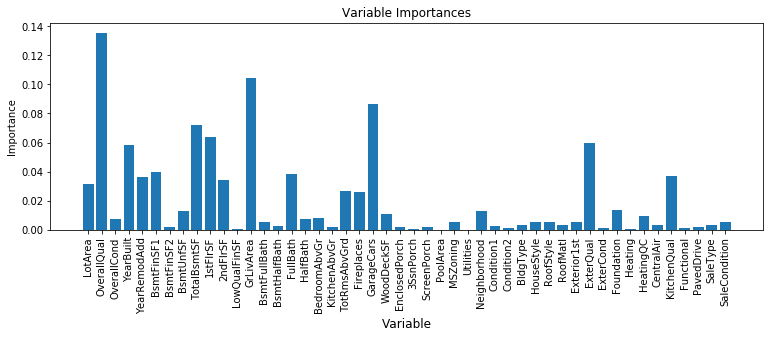

In [128]:
import matplotlib.pyplot as plt
# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, list(X6_train.columns), rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable', fontsize=12); plt.title('Variable Importances');

plt.tight_layout(rect=(0, 0, 1.8, 1.2))

In [182]:
# Select the most important features that sum up to 0.95 importance.

d = [imp for feature, imp in feature_importances[0:26]]
print('Total importance of 27 most important features :', round(sum(d),2))

# Collect the features in a list
top27_imp_features = list([feature for feature, imp in feature_importances[0:26]])

top27_imp_features

Total importance of 27 most important features : 0.95


['OverallQual',
 'GrLivArea',
 'GarageCars',
 'TotalBsmtSF',
 '1stFlrSF',
 'ExterQual',
 'YearBuilt',
 'BsmtFinSF1',
 'FullBath',
 'KitchenQual',
 'YearRemodAdd',
 '2ndFlrSF',
 'LotArea',
 'TotRmsAbvGrd',
 'Fireplaces',
 'Foundation',
 'Neighborhood',
 'BsmtUnfSF',
 'WoodDeckSF',
 'HeatingQC',
 'BedroomAbvGr',
 'HalfBath',
 'OverallCond',
 'MSZoning',
 'SaleCondition',
 'HouseStyle']

*It takes 27 most important features to sum up to 95% importance. In the following we re-train the model with only these 27 features.* 

In [183]:
# Fit the model again with these selected features

X8_train = X6_train[top27_imp_features]
X8_valid = X6_valid[top27_imp_features]

model.fit(X8_train, y_train)
preds = model.predict(X8_valid)
mean_absolute_error(y_valid, preds)

16011.120790629577

# Final model and features set

We will use the tuned model and the 27 chosen features to fit the final model and predict the prices from the test data.

In [228]:
# Process test data the same steps as the chosen features set gone through
#
X1_test = X_test_full.select_dtypes(exclude='object')
X1_test.drop(num_col_with_missing, axis=1, inplace=True)   # drop some numerical features

X2_test = X1_test.drop(['MoSold','MiscVal', 'GarageArea', 'OpenPorchSF', 'YrSold', 'MSSubClass'], axis=1)

# Note there are missing values in certain columns in test data and not in the same columns in training data
Xtest_cat_no_missing = X_test_full[categorical_var].drop(cat_col_with_missing, axis=1)
Xtest_cat_no_missing = Xtest_cat_no_missing.replace(np.nan, 'NaN')   # impute missing values in test data with 'NaN'

labelEncoded_test = Xtest_cat_no_missing.apply(label_encoder.fit_transform)  # label encode test set
X3_test = X2_test.join(labelEncoded_test)    # combine chosen numerical features and label encoded categorical features

X6_test = X3_test.drop(cols_to_drop, axis=1)   # drop some categorical features

X8_test = X6_test[top27_imp_features].replace(np.nan, -1)   # select only the most important 27 features
# There are missing values in numerical columns in test data, impute with -1


In [229]:
X8_test.isnull().sum()

OverallQual      0
GrLivArea        0
GarageCars       0
TotalBsmtSF      0
1stFlrSF         0
ExterQual        0
YearBuilt        0
BsmtFinSF1       0
FullBath         0
KitchenQual      0
YearRemodAdd     0
2ndFlrSF         0
LotArea          0
TotRmsAbvGrd     0
Fireplaces       0
Foundation       0
Neighborhood     0
BsmtUnfSF        0
WoodDeckSF       0
HeatingQC        0
BedroomAbvGr     0
HalfBath         0
OverallCond      0
MSZoning         0
SaleCondition    0
HouseStyle       0
dtype: int64

In [230]:
# Predict with final model
finalModel = model.fit(X8_train, y_train)
pred_test = finalModel.predict(X8_test) 

# Save test predictions to file
output = pd.DataFrame({'Id': X8_test.index,
                       'SalePrice': pred_test})
output.to_csv('submission3.csv', index=False)